In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [14]:
import os
import itertools
import time
import random
import numpy as np  
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Masking
from tensorflow.keras.optimizers import Adam


In [4]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  0
GPU device not found. Đảm bảo bạn đã chọn runtime GPU.


2025-04-22 00:40:54.785019: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
def flattern(p):
    pred_y_matrix = [[] for _ in range(len(p[0]))]
    for pp in p:
        a = pp.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]
    return pred_y_matrix


def interpolate(data, mask=-1):
    temp = [list(dd) for dd in data]
    d = []
    for i in range(len(temp)):
        # biến mask thành NaN để interpolate
        arr = [np.nan if x == mask else x for x in temp[i]]
        df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
        d.append(df.tolist())
    return d


def data_split(dat, train_hour, test_hour, predict_position, stride):
    x, y = [], []
    period = train_hour + predict_position + test_hour
    i = 0
    length = len(dat[0])
    while i + period <= length:
        x_temp, y_temp = [], []
        for series in dat:
            x_temp.append(series[i : i + train_hour])
            y_temp.append(series[
                i + train_hour + predict_position :
                i + train_hour + predict_position + test_hour
            ])
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    return np.array(x), np.array(y)


def split_train(int_dat, norm_dat, T1, T2, T3, stride, start, end, data_name=None):
    length = len(int_dat[0])
    s = int(length * start)
    e = int(length * end)

    # X train: normalize toàn bộ (loại đoạn test s:e), X test: lấy interpolate trên bản int_dat
    Train = [serie[:s] + serie[e:] for serie in norm_dat]
    Test = [serie[s:e] for serie in int_dat]

    print(f'Training series length: {len(Train[0])}; Test series length: {len(Test[0])}')
    train_x, train_y = data_split(Train, T1, T2, T3, stride)
    test_x, test_y = data_split(Test,  T1, T2, T3, stride)
    return train_x, train_y, test_x, test_y


def data_normalize(Dat, mask=-1):
    new_dat = []
    scaling = []
    for d in Dat:
        valid = [v for v in d if v != mask]
        mn = np.min(valid) if valid else 0
        mx = np.max(valid) if valid else 1
        normed = [(v - mn) / (mx - mn) if v != mask and mx != mn else v
                  for v in d]
        new_dat.append(normed)
        scaling.append((mn, mx))
    return new_dat, scaling


In [6]:
def load_and_align_data(sensor_files, variables, mask=-1):
    data = []
    variable_names = []
    time_index = None

    for _, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        time_index = df.index if time_index is None else time_index.intersection(df.index)

    for name, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        for var in variables:
            if var in df:
                series = df.loc[time_index, var].tolist()
                data.append(series)
                variable_names.append(f"{name}_{var}")

    return data, variable_names, time_index

def stacked_LSTM(X, Y, lstm_units=[32,], lr=1e-5):
    timesteps, n_features = X.shape[1], X.shape[2]
    out_dim = Y.shape[2]

    model = Sequential([
        Masking(mask_value=-1., input_shape=(timesteps, n_features)),
        Bidirectional(LSTM(lstm_units[0], activation='relu', return_sequences=True)),
        Dense(out_dim)
    ])
    model.compile(
        loss='mean_absolute_error',
        optimizer=Adam(learning_rate=lr)
    )
    early_stop = EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    # ép GPU nếu có
    import tensorflow as tf
    with tf.device('/GPU:0'):
        hist = model.fit(
            X, Y,
            epochs=50,
            batch_size=10,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

    model.summary()
    return model, hist


def SP_Learner(data, train_time, predict_time, predict_position, stride, start, end, data_name):
    # chuẩn hóa và interpolate
    norm_dat, scaling = data_normalize(data)
    interp_dat = interpolate(norm_dat, mask=-1)

    # tạo train/test sets
    train_x, train_y, test_x, test_y = split_train(
        interp_dat, norm_dat,
        train_time, predict_time, predict_position,
        stride, start, end, data_name
    )

    # train model
    model, hist = stacked_LSTM(train_x, train_y)
    pred_y = model.predict(test_x, verbose=1)

    return pred_y, test_y, model, scaling

In [7]:
def evaluate_model(pred_y, test_y, variable_names, scaling_params, time_index, start):
    results = {}
    for i, var in enumerate(variable_names):
        mn, mx = scaling_params[i]
        # reshape về 1d để evaluate
        pred_flat = pred_y[:, i, 0].ravel() * (mx - mn) + mn
        true_flat = test_y[:,i,0].ravel() * (mx - mn) + mn

        # xác định time axis
        s = int(len(time_index) * start)
        dates = pd.date_range(
            start=time_index[s],
            periods=len(pred_flat),
            freq=time_index[1] - time_index[0]
        )

        # tìm shift tối ưu
        metrics = []
        for sh in range(-20,1):
            sp = np.roll(pred_flat, sh)
            if sh<0: sp[sh:] = sp[sh-1]
            mae  = mean_absolute_error(true_flat, sp)
            rmse = np.sqrt(mean_squared_error(true_flat, sp))
            r2   = r2_score(true_flat, sp)
            mape = mean_absolute_percentage_error(true_flat+1e-10, sp+1e-10)*100
            metrics.append((sh, mae, rmse, r2, mape))
        best = min(metrics, key=lambda x: x[1])
        sh, mae0, rmse0, r20, mape0 = best

        plt.figure(figsize=(12,5))
        plt.plot(dates, np.roll(pred_flat, sh), label=f'Pred (shift {sh})')
        plt.plot(dates, true_flat, label='True')
        plt.legend(); plt.title(var); plt.tight_layout(); plt.show()

        print(f"\n{var} -> MAE:{mae0:.4f}, RMSE:{rmse0:.4f}, R²:{r20:.4f}, MAPE:{mape0:.2f}% (shift={sh})")

        results[var] = {
            'MAE': mae0, 'RMSE': rmse0, 'R2': r20, 'MAPE': mape0, 'shift': sh
        }
    return results

In [8]:
# Configuration settings
train_time = 325       # Training sequence length
predict_time = 4      # Prediction sequence length
predict_position = 12 # Gap between training and prediction
stride = 3            # Stride for sequence generation
start = 0.8            # Training data proportion
end = 1.0              # Test data proportion
variables = ['PM2_5.ug.m3.']  # Target variable(s) to extract from each sensor


# Model Hyperparameter
learning_rate = 1e-5      # Learning rate for Adam optimizer
patience = 15             # Early stopping patience
epochs = 50               # Maximum training epochs
batch_size = 16           # Training batch size
lstm_units = 32

base_path = 'V-IndoorCARE/data/15mins'

# Define all sensor files
all_sensors = {
    'sensor1': f'{base_path}01_15mins.csv',
    'sensor2': f'{base_path}02_15mins.csv',
    'sensor3': f'{base_path}03_15mins.csv',
    'sensor4': f'{base_path}04_15mins.csv'
}
# all_sensors = {
#     'sensor1': f'{base_path}LASER PULSE- PAM Air Trích xuất dữ liệu Quý IV 2022.csv.xlsx - Trường THCS An Lạc.csv',
#     'sensor2': f'{base_path}LASER PULSE- PAM Air Trích xuất dữ liệu Quý IV 2022.csv.xlsx - Trường THCS Lê Minh Xuân.csv',
#     'sensor3': f'{base_path}LASER PULSE- PAM Air Trích xuất dữ liệu Quý IV 2022.csv.xlsx - Trường Tiểu học An Lạc 2.csv',
#     # 'sensor4': f'{base_path}LASER PULSE- PAM Air Trích xuất dữ liệu Quý IV 2022.csv.xlsx - Trường Tiểu học Cầu Xáng.csv'
# }


Pair: sensor1 & sensor2


/tmp/ipykernel_5706/3948405620.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


Training series length: 103680; Test series length: 25920
Epoch 1/50


/home/nhat-minh/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/551 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1906

2025-04-22 00:33:53.584920: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1762 - val_loss: 0.0683
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1095 - val_loss: 0.0520
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0867 - val_loss: 0.0427
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0720 - val_loss: 0.0372
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0641 - val_loss: 0.0345
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0580 - val_loss: 0.0329
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0565 - val_loss: 0.0327
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0544 - val_loss: 0.0314
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0513 - val_loss: 0.0311
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0513 - val_loss: 0.0316
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0492 - val_loss: 0.0309
Epoch 12/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 2, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 2, 64)          │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2, 30)          │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


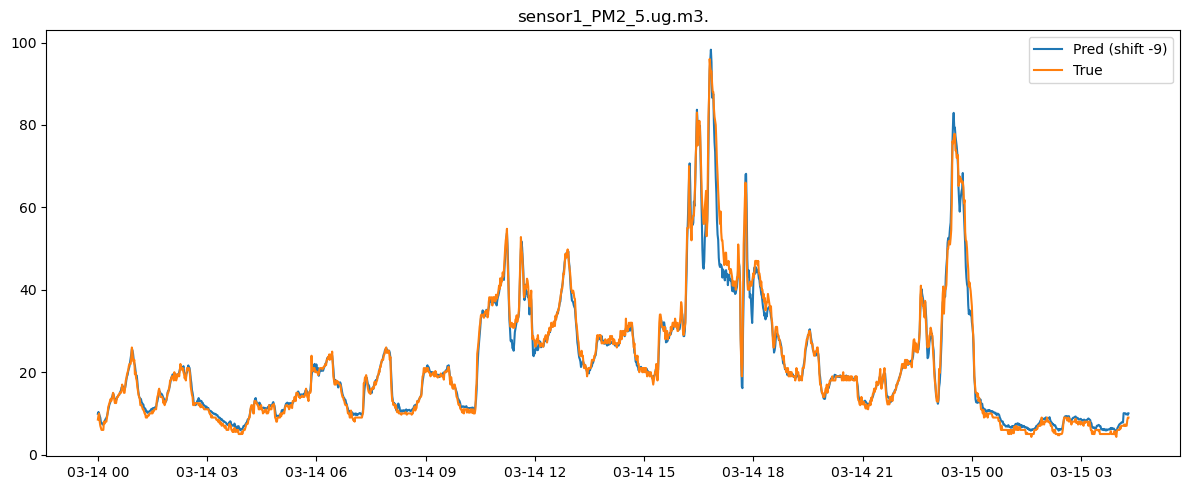


sensor1_PM2_5.ug.m3. -> MAE:1.2366, RMSE:2.0487, R²:0.9829, MAPE:6.96% (shift=-9)


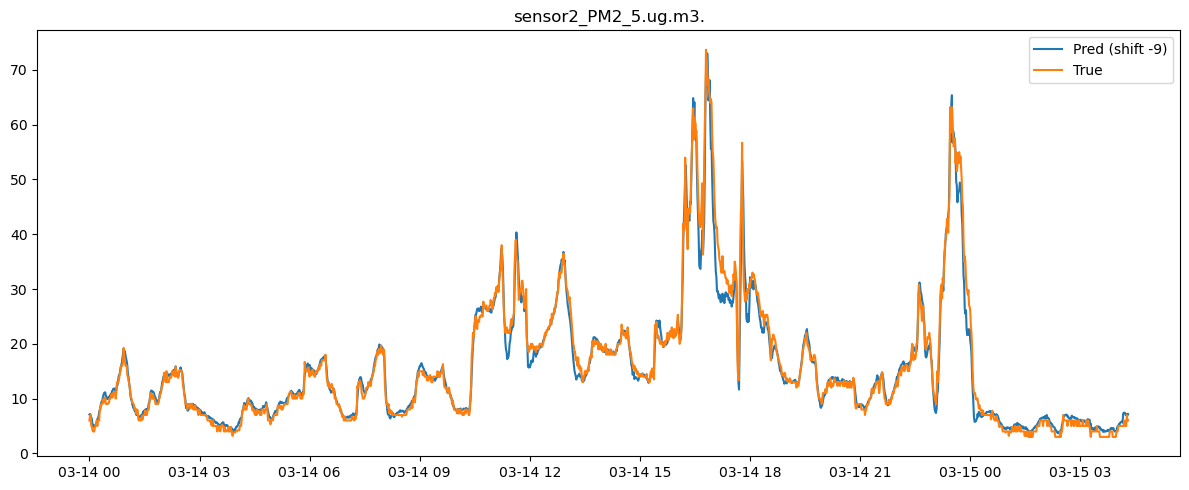


sensor2_PM2_5.ug.m3. -> MAE:1.1550, RMSE:1.9211, R²:0.9736, MAPE:8.66% (shift=-9)

Pair: sensor1 & sensor3


/tmp/ipykernel_5706/3948405620.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/home/nhat-minh/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training series length: 103680; Test series length: 25920
Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1576 - val_loss: 0.0621
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1010 - val_loss: 0.0453
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0765 - val_loss: 0.0383
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0673 - val_loss: 0.0357
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0608 - val_loss: 0.0343
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0582 - val_loss: 0.0333
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0549 - val_loss: 0.0325
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0537 - val_loss: 0.0320
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0522 - val_loss: 0.0318
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0515 - val_loss: 0.0307
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0504 - val_loss: 0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 2, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 2, 64)          │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2, 30)          │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


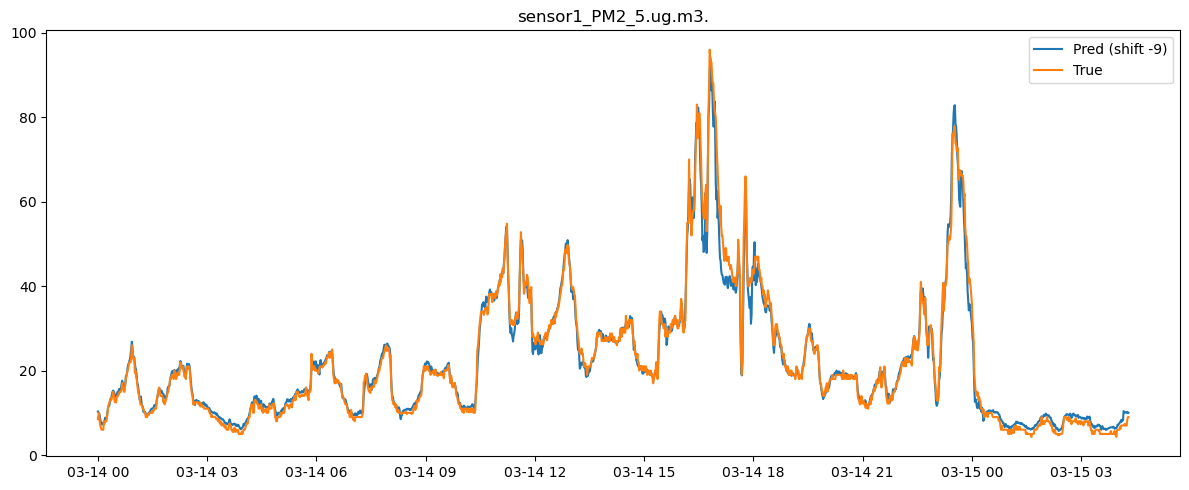


sensor1_PM2_5.ug.m3. -> MAE:1.3063, RMSE:2.0368, R²:0.9831, MAPE:7.70% (shift=-9)


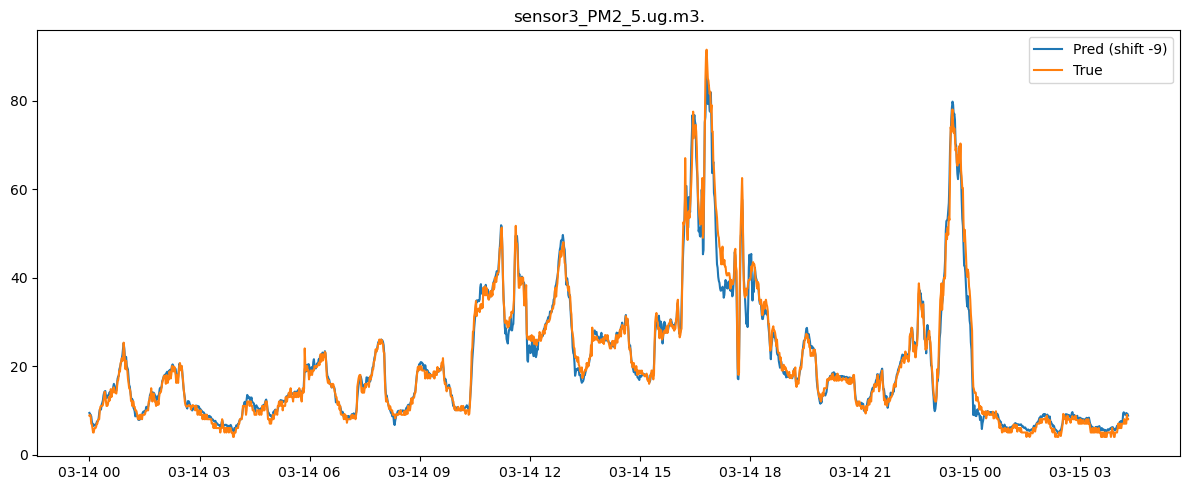


sensor3_PM2_5.ug.m3. -> MAE:1.2797, RMSE:1.9719, R²:0.9826, MAPE:7.47% (shift=-9)

Pair: sensor1 & sensor4


/tmp/ipykernel_5706/3948405620.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/home/nhat-minh/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training series length: 93891; Test series length: 23473
Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1564 - val_loss: 0.0732
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1067 - val_loss: 0.0566
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0857 - val_loss: 0.0468
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0739 - val_loss: 0.0411
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0644 - val_loss: 0.0373
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0590 - val_loss: 0.0352
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0551 - val_loss: 0.0339
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0520 - val_loss: 0.0332
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0503 - val_loss: 0.0321
Epoch 10/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0491 - val_loss: 0.0319
Epoch 11/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0472 - val_loss: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 2, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 2, 64)          │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2, 30)          │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


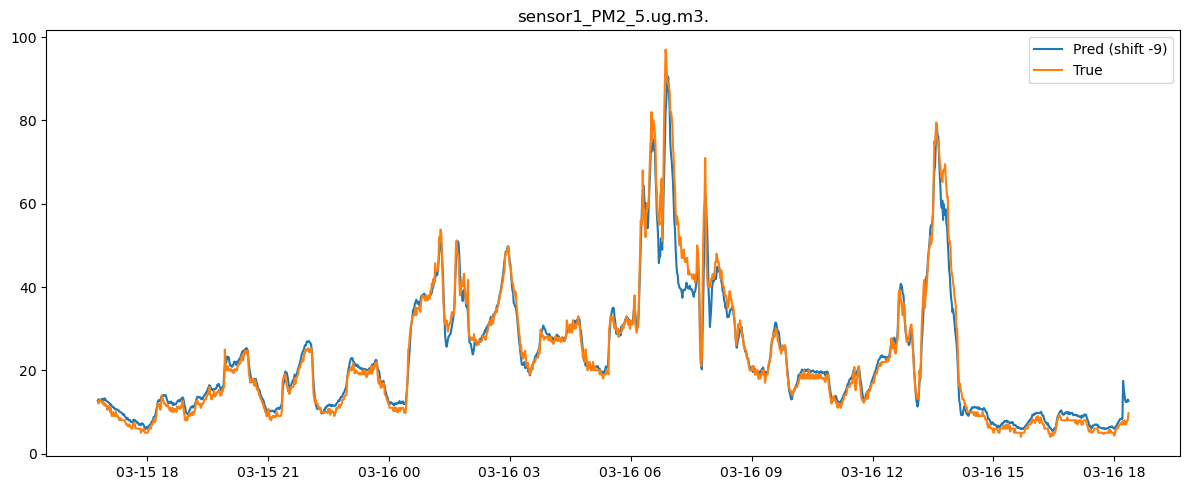


sensor1_PM2_5.ug.m3. -> MAE:1.7990, RMSE:2.7439, R²:0.9713, MAPE:9.95% (shift=-9)


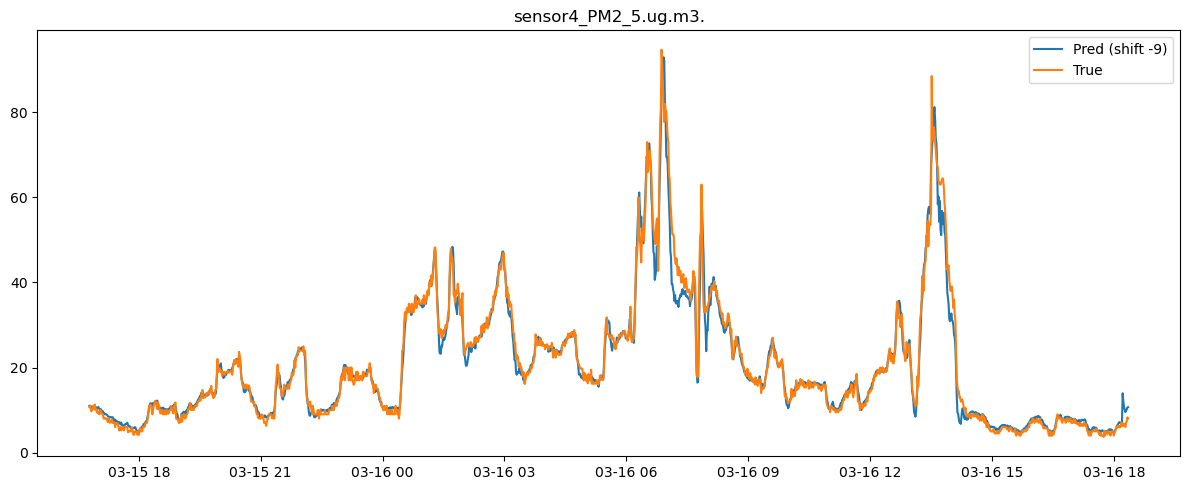


sensor4_PM2_5.ug.m3. -> MAE:1.4008, RMSE:2.4415, R²:0.9734, MAPE:7.47% (shift=-9)

Pair: sensor2 & sensor3


/tmp/ipykernel_5706/3948405620.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


Training series length: 103680; Test series length: 25920
Epoch 1/50


/home/nhat-minh/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1915 - val_loss: 0.0759
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1180 - val_loss: 0.0518
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0917 - val_loss: 0.0420
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0747 - val_loss: 0.0368
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0641 - val_loss: 0.0343
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0590 - val_loss: 0.0328
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0554 - val_loss: 0.0317
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0539 - val_loss: 0.0313
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0515 - val_loss: 0.0313
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0500 - val_loss: 0.0311
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0512 - val_loss: 0.0293
Epoch 12/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 2, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 2, 64)          │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2, 30)          │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


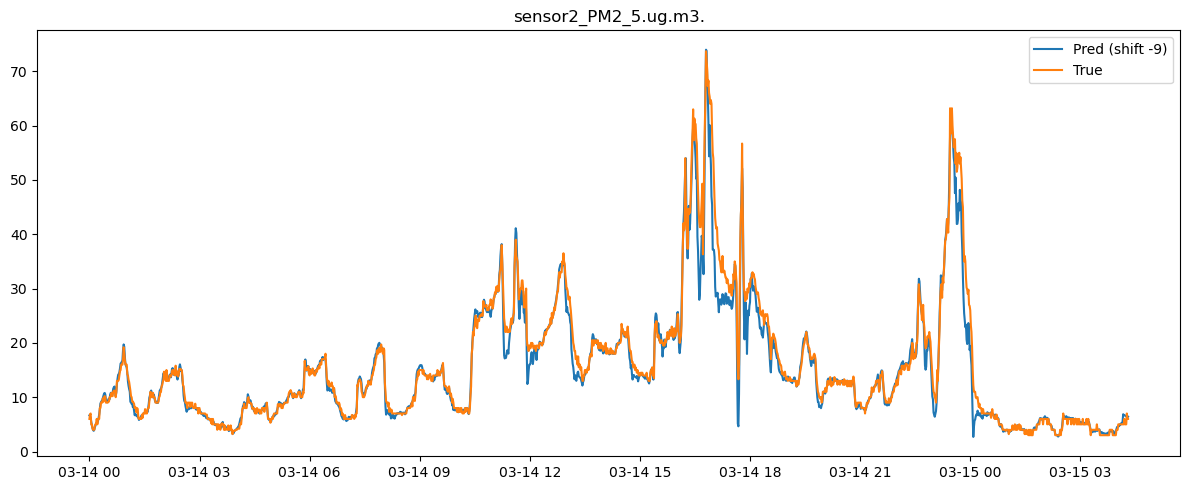


sensor2_PM2_5.ug.m3. -> MAE:1.2416, RMSE:2.4807, R²:0.9559, MAPE:6.96% (shift=-9)


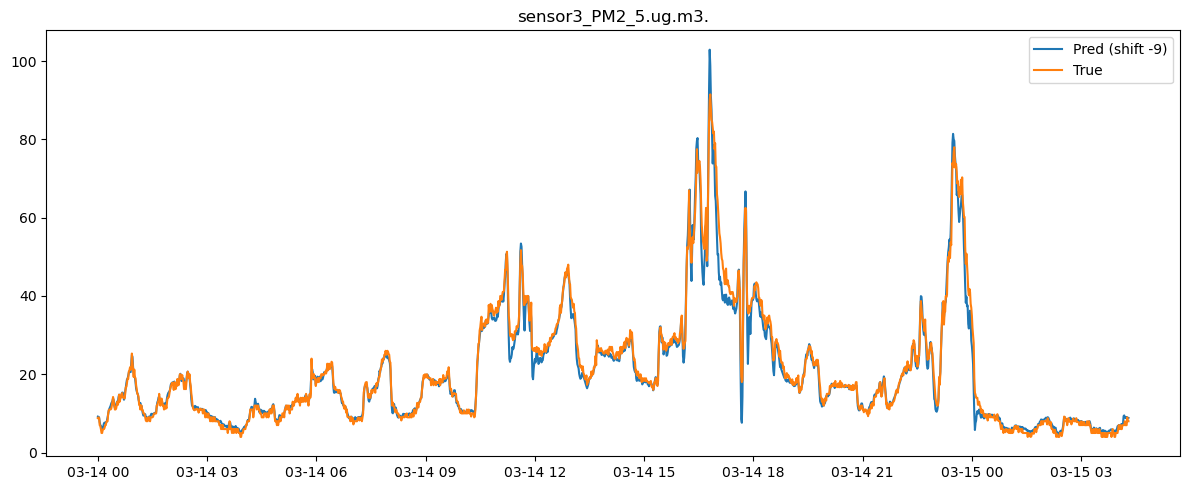


sensor3_PM2_5.ug.m3. -> MAE:1.3349, RMSE:2.3206, R²:0.9759, MAPE:6.91% (shift=-9)

Pair: sensor2 & sensor4


/tmp/ipykernel_5706/3948405620.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/home/nhat-minh/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training series length: 93891; Test series length: 23473
Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1503 - val_loss: 0.0689
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0994 - val_loss: 0.0502
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0787 - val_loss: 0.0424
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0708 - val_loss: 0.0378
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0615 - val_loss: 0.0349
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0561 - val_loss: 0.0336
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0527 - val_loss: 0.0322
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0502 - val_loss: 0.0315
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0504 - val_loss: 0.0308
Epoch 10/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0474 - val_loss: 0.0306
Epoch 11/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0459 - val_loss: 0.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 2, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 2, 64)          │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2, 30)          │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


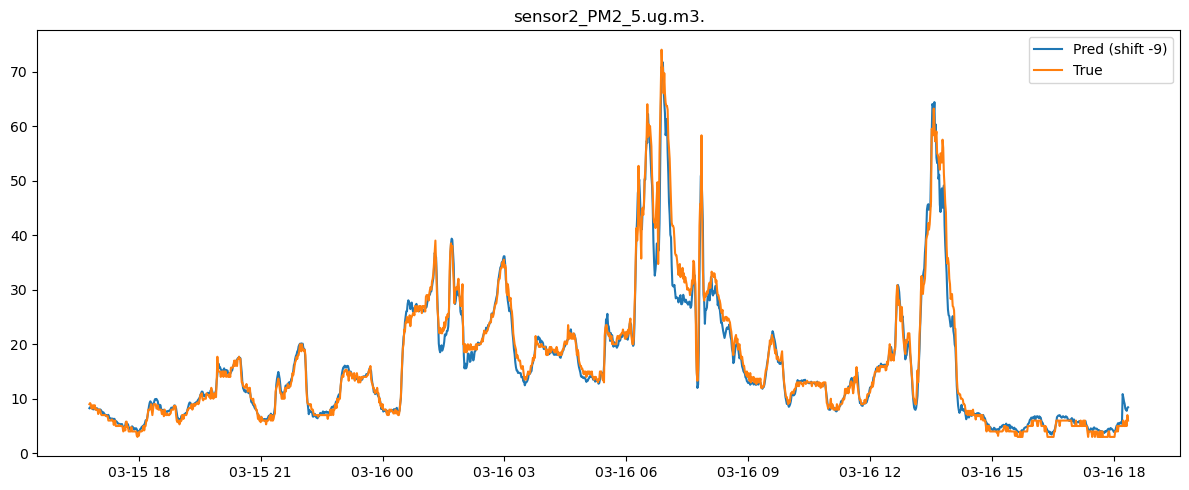


sensor2_PM2_5.ug.m3. -> MAE:1.2050, RMSE:2.0528, R²:0.9720, MAPE:8.14% (shift=-9)


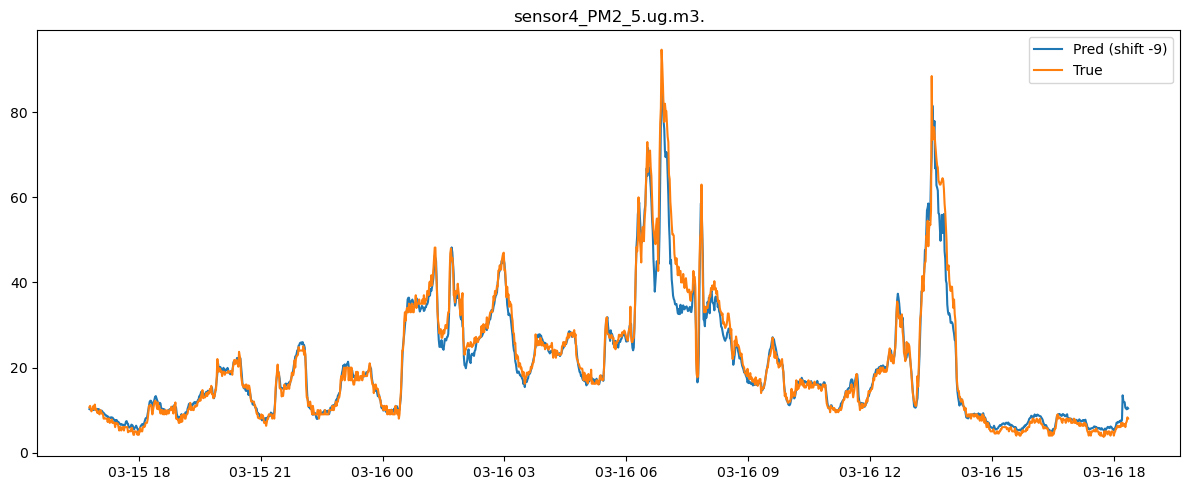


sensor4_PM2_5.ug.m3. -> MAE:1.6103, RMSE:2.7634, R²:0.9659, MAPE:8.54% (shift=-9)

Pair: sensor3 & sensor4


/tmp/ipykernel_5706/3948405620.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/home/nhat-minh/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training series length: 93891; Test series length: 23473
Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1521 - val_loss: 0.0693
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1040 - val_loss: 0.0529
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0826 - val_loss: 0.0440
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0693 - val_loss: 0.0385
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0629 - val_loss: 0.0354
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0559 - val_loss: 0.0337
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0527 - val_loss: 0.0327
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0515 - val_loss: 0.0321
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0487 - val_loss: 0.0313
Epoch 10/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0488 - val_loss: 0.0306
Epoch 11/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0478 - val_loss: 0.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 2, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 2, 64)          │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2, 30)          │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


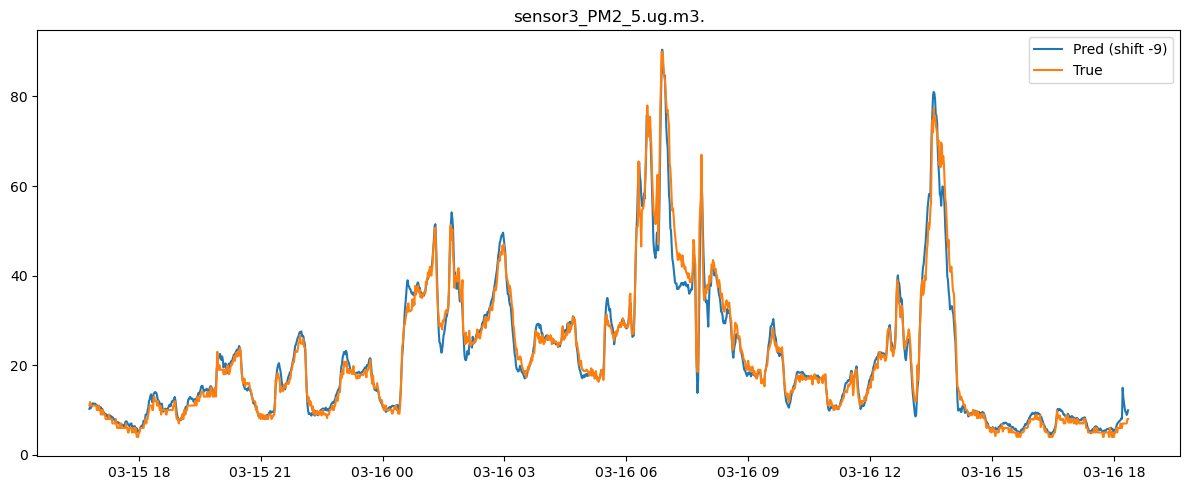


sensor3_PM2_5.ug.m3. -> MAE:1.6358, RMSE:2.5608, R²:0.9725, MAPE:8.53% (shift=-9)


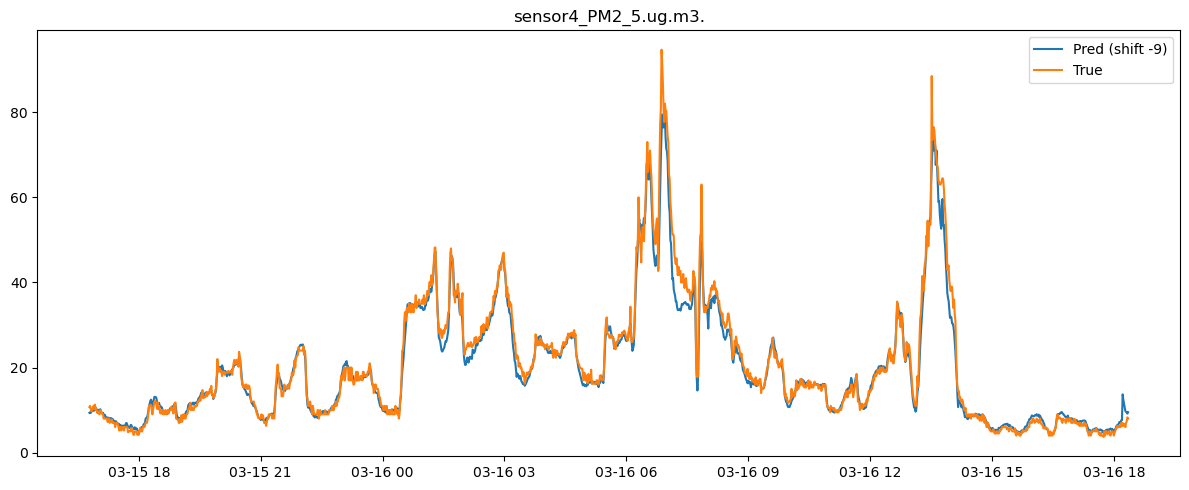


sensor4_PM2_5.ug.m3. -> MAE:1.4727, RMSE:2.4949, R²:0.9722, MAPE:7.51% (shift=-9)


In [13]:
if __name__ == "__main__":
    train_time = 300
    predict_time = 30
    predict_pos = 120
    stride = 15
    start, end = 0.8, 1.0
    variables = ['PM2_5.ug.m3.']

    base = '/home/nhat-minh/Desktop/NEU_Lab/V-IndoorCARE/data/1mins/'
    all_sensors = {
        'sensor1': f'{base}01_01mins.csv',
        'sensor2': f'{base}02_01mins.csv',
        'sensor3': f'{base}03_01mins.csv',
        'sensor4': f'{base}04_01mins.csv'
    }

    dual_results = {}
    for pair in itertools.combinations(all_sensors.keys(), 2):
        s1, s2 = pair
        print("\n", "="*40, f"\nPair: {s1} & {s2}")
        files = {s1: all_sensors[s1], s2: all_sensors[s2]}
        data, var_names, t_idx = load_and_align_data(files, variables)
        if not data:
            print("No data, skip.")
            continue
        pred, true, mdl, scale = SP_Learner(
            data, train_time, predict_time, predict_pos,
            stride, start, end, f"{s1}_{s2}"
        )
        res = evaluate_model(pred, true, var_names, scale, t_idx, start)
        dual_results[f"{s1}_{s2}"] = res

In [9]:
def load_and_align_data(sensor_files, variables, mask=-1):
    # --- như trước ---
    data, variable_names, time_index = [], [], None
    for _, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        time_index = df.index if time_index is None else time_index.intersection(df.index)
    for name, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        for var in variables:
            if var in df.columns:
                data.append(df.loc[time_index, var].tolist())
                variable_names.append(f"{name}_{var}")
    return data, variable_names, time_index

def build_model(timesteps, n_features, out_dim, lstm_units=[64,32], lr=1e-4):
    m = Sequential([
        Masking(mask_value=-1., input_shape=(timesteps, n_features)),
        Bidirectional(LSTM(lstm_units[0], activation='relu', return_sequences=True)),
        Bidirectional(LSTM(lstm_units[1], activation='relu', return_sequences=True)),
        Dense(out_dim)
    ])
    m.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=lr))
    return m

In [10]:
def SP_Learner_3to1(data_in, data_out,
                   train_time, test_time, pred_pos, stride, start, end):
    norm_in, scale_in   = data_normalize(data_in)
    norm_out, scale_out = data_normalize(data_out)
    interp_in  = interpolate(norm_in, mask=-1)
    interp_out = interpolate(norm_out, mask=-1)

    tx, ty_all, vx, vy_all = split_train(
        interp_in, norm_in,
        train_time, test_time, pred_pos, stride, start, end
    )

    model = build_model(
        timesteps = tx.shape[1],
        n_features = tx.shape[2],
        out_dim    = ty_all.shape[2],
        lstm_units = [64,32],
        lr         = 1e-4
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    with __import__('tensorflow').device('/GPU:0'):
        hist = model.fit(
            tx, ty_all,
            epochs=75,
            batch_size=16,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

    pred = model.predict(vx, verbose=1)
    return pred, vy_all, model, scale_out

#

In [ ]:
if __name__ == "__main__":
    train_time   = 300
    test_time    = 30
    pred_pos     = 120
    stride       = 15
    start, end   = 0.8, 1.0
    variables    = ['PM2_5.ug.m3.']
    base_path    = 'data/1mins/'
    all_sensors  = {
        'sensor1': f'{base_path}01_01mins.csv',
        'sensor2': f'{base_path}02_01mins.csv',
        'sensor3': f'{base_path}03_01mins.csv',
        'sensor4': f'{base_path}04_01mins.csv',
    }

    data_all, names_all, time_index = load_and_align_data(all_sensors, variables)

    data_in  = [data_all[i] for i in [1, 2, 3]]  # sensor1, sensor3, sensor4
    data_out = [data_all[0]]  # sensor2

    pred_y, true_y, model, scaling = SP_Learner_3to1(
        data_in, data_out,
        train_time, test_time, pred_pos, stride, start, end
    )

    preds = pred_y[:, :, 0]
    print("Các giá trị dự đoán cho sensor3 ")
    print(preds)

    import pandas as pd

    col_names = [f"step_{i+1}" for i in range(preds.shape[1])]
    df_preds = pd.DataFrame(preds, columns=col_names)

    df_preds.index.name = "window_idx"

    out_csv = "predictions_sensor1(1mins).csv"
    df_preds.to_csv(out_csv, index=True)
    print(f"Đã lưu dự đoán vào file: {out_csv}")

    res = evaluate_model(
        pred_y, true_y,
        ['sensor1_' + variables[0]],
        scaling, time_index, start
    )
    print(res)


/tmp/ipykernel_34830/3948405620.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


Training series length: 93891; Test series length: 23473
Epoch 1/75


/home/nhat-minh/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1201 - val_loss: 0.0313
Epoch 2/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0465 - val_loss: 0.0279
Epoch 3/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0423 - val_loss: 0.0283
Epoch 4/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0406 - val_loss: 0.0264
Epoch 5/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0386 - val_loss: 0.0256
Epoch 6/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0392 - val_loss: 0.0269
Epoch 7/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0380 - val_loss: 0.0261
Epoch 8/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0365 - val_loss: 0.0250
Epoch 9/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0379 - val_loss: 0.0252
Epoch 10/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0381 - val_loss: 0.0259
Epoch 11/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0370 - val_loss: 0.0254
Epoch 12/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.